In [4]:
import csv, sqlite3, unicodedata, unidecode, datetime #vou usar o sqlite3 para a análise
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from tools import utils

In [7]:
utils = utils() #criando objeto da classe utils

O primeiro passo é criar um banco de dados e uma table para cada um dos arquivos .csv disponibilizados

In [78]:
conn = sqlite3.connect("ton.db") #criando um db
c = conn.cursor()

c.execute("""CREATE TABLE cases 
            (accountid,
            date_ref,
            channelid,
            waitingtime,
            missed,
            pesquisa_de_satisfa_o__c,
            assunto,
            Id
            )""") #criando a table cases

with open('cases.csv','r') as fin: # para preencher a table vou utilzar o arquivo cases.csv
    # csv.DictReader usa a primeira linha do arquivo como titulo para as colunas
    dr = csv.DictReader(fin) # a virgula é o delimitador por default
    to_db = []
    for row in dr:
        if row['accountid'] !='': #o arquivo .csv apresenta linhas vazias, entao filtro isso aqui
            processed_row = utils.processing(row, 'cases')#uso a função processing da classe utils
            to_db.append(processed_row)

c.executemany("INSERT INTO cases VALUES (?, ?, ?, ?, ?, ?, ?, ?);", to_db) #pronto
conn.commit()
conn.close()            

In [28]:
conn = sqlite3.connect("ton.db")
c = conn.cursor()

c.execute("""CREATE TABLE creds
            (cred_date,
            shipping_address_city,
            shipping_address_state,
            max_machine,
            accountid
            )""") #criando a table creds

with open('creds.csv','r', encoding='utf-8') as fin: 
    dr = csv.DictReader(fin) # comma is default delimiter
    to_db = []
    for row in dr:
        if row['accountid'] != '': #linhas de chamados que não aprensentam o campo accountid foram filtradas
            processed_row = processing(row, 'creds')
            to_db.append(processed_row)

c.executemany("INSERT INTO creds VALUES (?, ?, ?, ?, ?);", to_db)

conn.commit()
conn.close()  

Para a questão 1 devemos calcular o numero de chamados que tiveram como assunto o Produto, e também irei contar o número de clientes credenciados ao longo do tempo

In [26]:
conn = sqlite3.connect('ton.db')

#create cursor
c = conn.cursor()

#query the database
c.execute("SELECT date_ref FROM cases WHERE assunto LIKE 'Produto%' ORDER BY date_ref ASC") 
#faço um query com as datas dos chamados que tem como assunto o produto

chamados = np.array(c.fetchall())

c.execute("SELECT cred_date FROM creds ORDER BY cred_date ASC")
#faço um query com as datas que clientes foram credenciados

empresas = np.array(c.fetchall())

#close connection
conn.close()

In [38]:
month_calls = count(utils.transform_array(chamados))
month_cred = count(utils.transform_array(empresas))#transformo as strings para o formato datetime

Acredito que as função abaixo não se encaixariam na classe utils para melhorar a visualização do raciocínio

In [35]:
def count(array):
    month_count=[[],[],[],[],[],[],[],[],[],[]] #os meses contabilzados vão de [fevereiro - Setembro]
    
    for date in array:
        month = date[0].month
        year = date[0].year
        
        if(year ==2019 or month == 1): #para os casos dos clientes credenciados, temos datas do ano de 2019
        #enquanto os chamados começam a partir de fevereiro de 2020, por isso no mes de fevereiro será contabilizado
        #a quantidade de clientes credenciados no intervalo (-inf - fevereiro]
            month_count[0].append(date)
        else:
            month_count[month - 2].append(date) #aqui é para os casos dentro do intevalo [fevereiro - Setembro]
    
    return month_count

In [77]:
def accumulated(array,num): #calcula a soma de elementos de um array com base num range
    #exemplo: se num 2, o output sera a soma dos primeiros 2 termos do array
    accumulated=0
    for number in range(0,num):
        accumulated += len(array[number])
        
    return accumulated #na pratica tera o output do numero de clientes acumulado ao longo dos meses

Com as funções prontas, vamos plotar um gráfico que irá mostrar o número de chamados com assunto de produtos e também com o número acumulado de clientes ao longo do tempo.

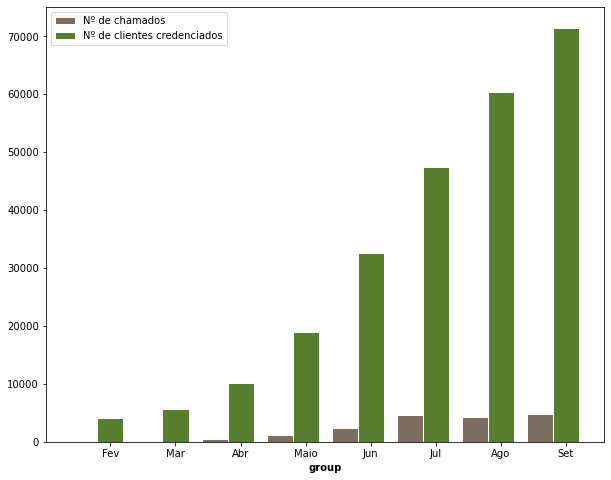

In [78]:
fig = plt.figure(figsize=(10,8))

barWidth = 0.4
 
# set height of bar
bars1 = [len(month_calls[0]), len(month_calls[1]), len(month_calls[2]), len(month_calls[3]), len(month_calls[4]),
        len(month_calls[5]),len(month_calls[6]),len(month_calls[7])]#chamados 
bars2 = [accumulated(month_cred,1), accumulated(month_cred,2), accumulated(month_cred,3), accumulated(month_cred,4)
         ,accumulated(month_cred,5),accumulated(month_cred,6),accumulated(month_cred,7),accumulated(month_cred,8)]
#numero de clientes acumulados

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Nº de chamados')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Nº de clientes credenciados')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Fev', 'Mar', 'Abr', 'Maio', 'Jun','Jul','Ago','Set'])

plt.legend()
plt.show()

Realizando a análise, em números absolutos o numero de chamados com o assunto sobre produtos diminui levemente no mês de Agosto em relação a Julho e no mês de Setembro volta a subir novamente como podemos ver no gráfico e a seguir

In [88]:
print('Razão do numero de chamados em Agosto em relação aos de Julho: ' + str(bars1[-2]/bars1[-3])+'\n')
print('Razão do numero de chamados em Setembro em relação aos de Julho: ' + str(bars1[-1]/bars1[-3])+'\n')

Razão do numero de chamados em Agosto em relação aos de Julho: 0.9271750805585393

Razão do numero de chamados em Setembro em relação aos de Julho: 1.0337271750805586



O objetivo de diminuir os numeros absolutos de chamados sobre o produto foi atingido no primeiro mês e logo depois volta a subir. Porém também devemos perceber que o número de clientes credenciados acumulados aumenta de forma bem acentuada com o passar dos meses, o que também deve ser levado em conta!<br>
Por isso, uma estimativa foi feita da taxa de chamados ralizados por produto e o numero de clientes acumulados mensais. Os resultados são mostrados abaixo.

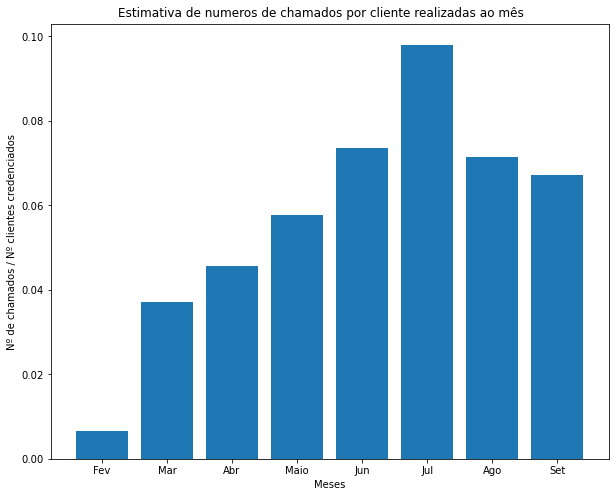

In [85]:
fig = plt.figure(figsize=(10,8))
rate = [bars1[0]/bars2[0], bars1[1]/bars2[1],bars1[2]/bars2[2],bars1[3]/bars2[3],
               bars1[4]/bars2[4], bars1[5]/bars2[5],bars1[6]/bars2[6],bars1[7]/bars2[7]]
bar = plt.bar(x = ['Fev', 'Mar', 'Abr', 'Maio', 'Jun','Jul','Ago','Set'],
     height = rate, width=0.8, bottom=None,align='center', data=None)

axes = plt.gca()
axes.set_ylabel('Nº de chamados / Nº clientes credenciados')
axes.set_xlabel('Meses')
plt.suptitle('Estimativa de numeros de chamados por cliente realizadas ao mês', y=0.91)       

plt.show()

Apesar do estimador apresentar erros, pois o numero de clientes aumenta diariamente e não mensalmente de uma vez só, podemos estiamar o comportamento do numero de chamados por cliente ao longo do tempo.<br>
Com isso, podemos perceber uma queda bem acentuada após o pico em Julho, que se estabiliza um pouco em Setembro.<br>
Podemos ver que a funcionalidade nova no site cumpriu seu papel!

In [89]:
print('Razão entre a estimativa de chamados por cliente em Agosto em relação a Julho: ' + str(rate[-2]/rate[-3])+'\n')
print('Razão entre a estimativa de chamados por cliente em Setembro em relação a Julho:' + str(rate[-1]/rate[-3])+'\n')

Razão entre a estimativa de chamados por cliente em Agosto em relação a Julho: 0.7297245444348179

Razão entre a estimativa de chamados por cliente em Setembro em relação a Julho:0.686403983195881



Para a questão dois, a minha primeira ideia foi trazer um histograma de chamados de clientes mais recentes logo após seu credenciamento e comparar com o de mais antigos. Porém os histogramas apresentariam valores diferente, tendo em vista que o numero de clientes é diretamente com o numero de chamados.<br>

Com isso resolvi comparar os valores médios de chamadas de clientes logo após o credenciamento divido pelo numero de clientes que realizaram chamadas nesse período.

In [8]:
conn = sqlite3.connect('ton.db')

#create cursor
c = conn.cursor()

#query the database
c.execute("""SELECT creds.accountid FROM creds WHERE cred_date >= '2020-09-30'""")
#query de clientes mais recentes

new_clients = c.fetchall() 

c.execute("""SELECT creds.accountid FROM creds WHERE cred_date < '2020-06-30'""")
#query de clientes mais antigos

older_clients = c.fetchall()

c.execute("""SELECT creds.accountid FROM creds""")
#query de todos os clientes

clients = c.fetchall()

#commit our command
conn.commit()

#close connection
conn.close()

In [10]:
def query_interval(array,key): #função que realiza um query e retorna

    conn = sqlite3.connect('ton.db')

    #create cursor
    c = conn.cursor()

    sum_gap = np.array([0, 0, 0, 0])

    client = 0

    for id in array:

        #query the database
        c.execute("""SELECT creds.cred_date, cases.date_ref  
                    FROM cases, creds on cases.accountid = creds.accountid 
                    WHERE cases.accountid=(?) """, id)#uma query para cada id retornando um array com as datas
        # de credenciamento e de chamadas 

        join_query = c.fetchall()
        client_calls = np.array(utils.client_calls(join_query, key)) #explicação da função no arquivo utils 

        sum_gap += client_calls
        client += 1


    #commit our command
    conn.commit()

    #close connection
    conn.close()
    
    return sum_gap, client

In [192]:
sum_gap_new, new_client = query_interval(new_clients,'short') 
print(sum_gap_new,new_client) #explicação da função no arquivo utils

[ 9226  5104 10345 21778] 6453


Gráfico clientes mais recentes

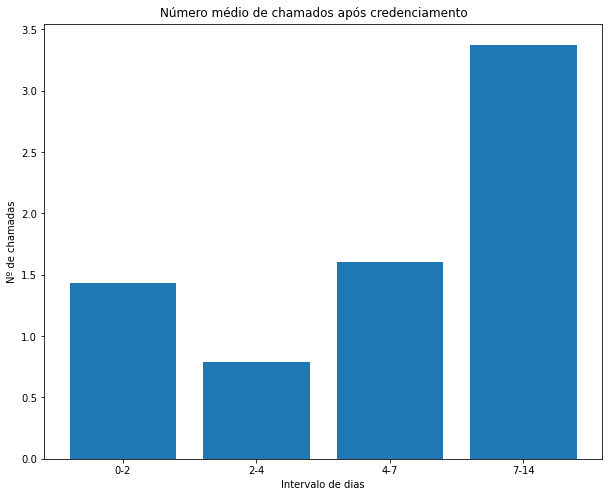

In [198]:
fig = plt.figure(figsize=(10,8))
bar = plt.bar(x = ['0-2', '2-4','4-7','7-14'],
     height = [sum_gap_new[0]/new_client, sum_gap_new[1]/new_client,
               sum_gap_new[2]/new_client, sum_gap_new[3]/new_client], 
     width=0.8, bottom=None,align='center', data=None)

axes = plt.gca()
axes.set_ylabel('Nº de chamadas')
axes.set_xlabel('Intervalo de dias')
plt.suptitle('Número médio de chamados após credenciamento', y=0.91)       

plt.show()

In [196]:
sum_gap_older, older_client = query_interval(older_clients,'short')
print(sum_gap_older, older_client)

[ 39896  33700  52878 143777] 31970


Clientes mais antigos

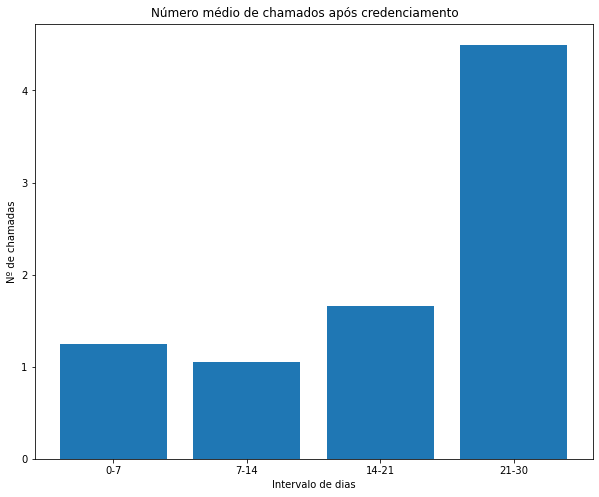

In [197]:
fig = plt.figure(figsize=(10,8))
bar = plt.bar(x = ['0-2', '2-4','4-7','7-14']
              ,
     height = [sum_gap_older[0]/older_client, sum_gap_older[1]/older_client,
               sum_gap_older[2]/older_client, sum_gap_older[3]/older_client], 
     width=0.8, bottom=None,align='center', data=None)

axes = plt.gca()
axes.set_ylabel('Nº de chamadas')
axes.set_xlabel('Intervalo de dias')
plt.suptitle('Número médio de chamados após credenciamento', y=0.91)       

plt.show()

É possível perceber uma diferença nos 7 primeiros dias de credenciamento.<br>
Enquanto clientes mais recentes fazem mais chamados no período de 0-2 dias após credenciamento, clientes mais antigos 
fizeram em media mais chamados no período de 2-4 dias. Além de termos uma diferença no período de 7-14 dias. 

Para a questão 3, o método de clusterização seria com base no tempo de credenciamento e o chamado. Como podemos ver no gráfico abaixo do numero de chamados médios nos primeiros 60 após a homologação, temos um numero de chamados bem expressivo nos primeiros dias.<br>
A ideia seria priorizar os clientes no seu primeiro mês, pois além de passar uma segurança maior para os mesmos, provavelmente são problemas e dúvidas mais fáceis de serem resolvidas e que provavelmente já possuem um certo protocolo. 

In [11]:
sum_gap,client = query_interval(clients,'long')

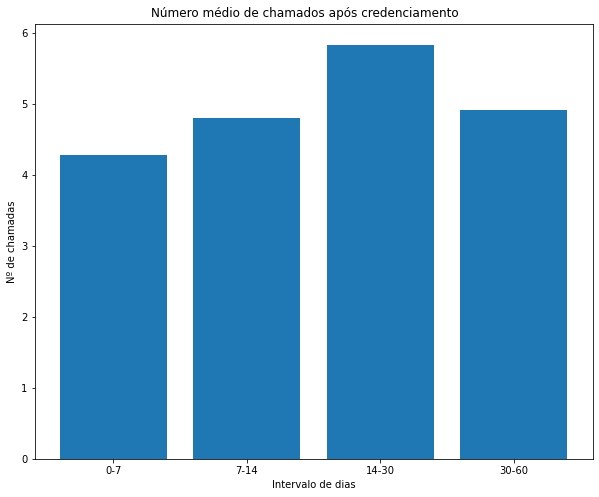

In [12]:
fig = plt.figure(figsize=(10,8))
bar = plt.bar(x = ['0-7', '7-14','14-30','30-60']
              ,
     height = [sum_gap[0]/client, sum_gap[1]/client,
               sum_gap[2]/client, sum_gap[3]/client], 
     width=0.8, bottom=None,align='center', data=None)

axes = plt.gca()
axes.set_ylabel('Nº de chamadas')
axes.set_xlabel('Intervalo de dias')
plt.suptitle('Número médio de chamados após credenciamento', y=0.91)       

plt.show()

Para a questão 4 basta usar as funções ja desenvolvidas!<br>
Incompleta.

In [ ]:
def cluster_query:
    
    query_result = []
    
    conn = sqlite3.connect('ton.db')

    #create cursor
    c = conn.cursor()
    
    c.execute("""SELECT creds.accountid FROM creds""")
    #query de todos os clientes

    clients = c.fetchall()

    for id in array:

        #query the database
        c.execute("""SELECT creds.cred_date, cases.date_ref  
                    FROM cases, creds on cases.accountid = creds.accountid 
                    WHERE cases.accountid=(?) """, id)#uma query para cada id retornando um array com as datas
        # de credenciamento e de chamadas 

        join_query = c.fetchall()
        client_calls = np.array(utils.client_calls(join_query, key)) #explicação da função no arquivo utils 

        sum_gap += client_calls
        client += 1
        
    #commit our command
    conn.commit()

    #close connection
    conn.close()